# N-Body Project 
## Anshak Mallik <br> Computational Astrophysics HS23

Libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Task 1

### 1.1 Step 1
- Preliminarly, **verify the form of the density function $\rho(r)$** by inferring it from the particle distrbution and **compare it with the analytical denstiy function described in the original paper by Hernquist** (from 1990 on Astrophysical Journal available on the web). **Use Poissonian error bars** when comparing the numerical density profile with the analytical expected values.

- Note that the initial conditions are given in a system of units in which $G=1$. **Assume reasonable units of length and mass** for your calculations (nuits of veloctiy and time follow automatically from the assumption) and **discuss your choice**.

Importing the data from data.txt

In [2]:
filepath = r'data.txt'
column_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'softening', 'potential']
data = pd.read_csv(filepath, delimiter='\t', names=column_names)

Calculating and storing the distance from the center and velocity of each star in 2 new columns: <br>
$r = \sqrt{x^2 + y^2 + z^2}$ and $v = \sqrt{v_x^2 + v_y^2 + v_z^2}$

In [3]:
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
data['velocity'] = np.sqrt(data['vx']**2 + data['vy']**2 + data['vz']**2)

In [56]:
data

,mass,x,y,z,vx,vy,vz,softening,potential,distance,velocity
0,92.4259,-0.003816,-0.079670,-0.019072,3779.6200,354.734,-73.45010,0.1,0.013022,0.082010,3796.940673
1,92.4259,-0.032298,-0.249461,-0.010890,3250.5900,-674.280,-18.33470,0.1,0.013022,0.251779,3319.838103
2,92.4259,0.067577,-0.810356,-0.006849,2190.8600,199.053,3.86061,0.1,0.013022,0.813198,2199.887393
3,92.4259,-0.152755,0.276704,-0.002704,-2695.1400,-1345.020,105.94600,0.1,0.013022,0.316080,3013.981250
4,92.4259,-0.216623,0.150557,-0.002755,-1811.8900,-2595.570,85.85910,0.1,0.013022,0.263819,3166.591351
...,...,...,...,...,...,...,...,...,...,...,...
50005,92.4259,-0.034591,-0.004853,0.038082,2274.8300,4239.630,-225.45900,0.1,0.013022,0.051675,4816.652969
50006,92.4259,0.100105,-0.006709,-0.025669,-751.0680,-1963.650,113.92200,0.1,0.013022,0.103561,2105.469707
50007,92.4259,0.045565,-0.075928,0.023182,-782.9830,581.401,608.46500,0.1,0.013022,0.091535,1149.486475
50008,92.4259,0.273587,0.567563,0.255294,-20.4115,-212.075,-715.19100,0.1,0.013022,0.679818,746.251031


Plotting the data to look at the what the star cluster looks like.

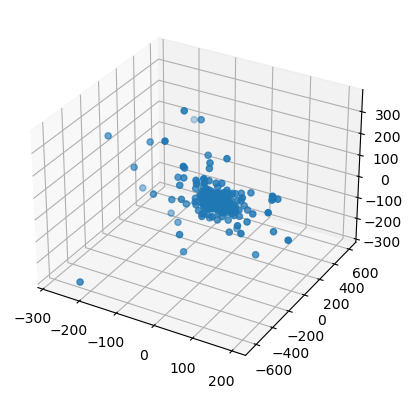

In [5]:
x = data['x'].to_numpy()
y = data['y'].to_numpy()
z = data['z'].to_numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)

In [6]:
# cluster = plt.figure()
# ax = cluster.add_subplot(projection='3d')
# ax.scatter(x, y, z)

# import plotly.express as px
# fig = px.scatter_3d(data, x='x', y='y', z='z', title='3D Scatter Plot', size_max = 1)
# fig.update_layout(scene=dict(xaxis_title='X Label', yaxis_title='Y Label', zaxis_title='Z Label'))
# fig.show()

Histogram

(array([4.9735e+04, 1.5400e+02, 4.4000e+01, 1.9000e+01, 1.3000e+01,
        1.2000e+01, 5.0000e+00, 6.0000e+00, 4.0000e+00, 4.0000e+00,
        6.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([3.65604928e-04, 2.41566753e+01, 4.83129851e+01, 7.24692948e+01,
        9.66256046e+01, 1.20781914e+02, 1.44938224e+02, 1.69094534e+02,
        1.93250844e+02, 2.17407153e+02, 2.41563463e+02, 2.65719773e+02,
        2.89876082e+02, 3.14032392e+02, 3.38188702e+02, 3.62345012e+02,
        3.86501321e+02, 4.10657631e+02, 4.34813941e+02, 4.58970251e+02,
        4.83126560e+02, 5.07282870e+02, 5.31439180e+02, 5.55595490e+02,
        5.79751799e+02, 6.03908109e+02, 6.28064419e+02, 6.52220729e+02,
        6.76377038e+02, 7.00533348e+02, 7.24689658e+02]),
 <BarContainer object of 30 

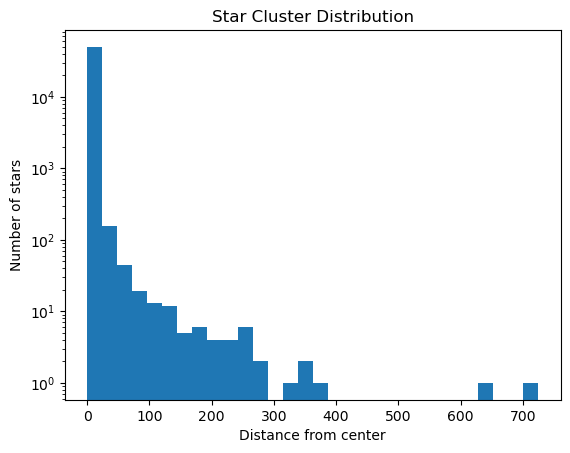

In [46]:
plt.figure()
plt.title('Star Cluster Distribution')
plt.xlabel('Distance from center')
plt.ylabel('Number of stars')
plt.hist(data['distance'], bins=30, log=True)
#First output is array of frequencies (y)
#Second output is array of bin edges (length = bins+1)

In [60]:
plt.hist?

Setting the right units for the $G=1$ case:

Verifying the Hernquist profile: $\rho(r) = \frac{M}{2\pi} \frac{a}{r} \frac{1}{(r+a)^3}$ <br>
Here, $M$ is the total mass and $a$ is the scale length. 

The Hernquist paper also defines the cumulative mass distribution corresponding to the Hernquist density profile as: $M(r) = M \frac{r^2}{(r+a)^2}$. This means, that at $r=a$ the cumulative mass distribution is a quarter of the total mass: $M(a) = M/4$. From this it follows, that the half-mass radius $R_{\text{hm}}$ and scale length relate in the following way: $R_{\text{hm}} = (1 + \sqrt{2})a$.

In [8]:
#Total mass of all stars
total_mass = np.sum(data['mass'].to_numpy())
print('The total mass of all stars is M = {:.0f} UNITS!'.format(total_mass))

The total mass of all stars is M = 4622219 UNITS!


To get the half-mass radius $R_{\text{hm}}$, we can do the following steps:
- Get indices of stars that would sort them by the distance in ascending order (np.argsort)
- Sort the stars by their mass and distance using the indices
- Create array with the cumulative sum of all star mass-es (np.cumsum)
- Set up a condition to get the index where the half-mass is reached
- Get the half-mass radius $R_{\text{hm}}$ using that index

In [27]:
#Getting the indices to sort stars by increasing distances
sort_dist_ind = np.argsort(data['distance'])

#Sort the star masses and distances using these indices
sort_mass = data['mass'][sort_dist_ind]
sort_dist = data['distance'][sort_dist_ind]

#Cumulative sum of mass of whole system
cum_mass = np.cumsum(sort_mass)

#Find index for half-mass and obtain half-mass radius from it
half_mass_ind = np.argmax(cum_mass >= total_mass/2)
half_mass_rad = sort_dist[half_mass_ind]
print('The half-mass radius of the star cluster lies at R_hm = {:.4f} UNITS!'.format(half_mass_rad))

The half-mass radius of the star cluster lies at R_hm = 6.9372 UNITS!


Using the half-mass radius $R_{\text{hm}}$, we can make a guess for the scale length:

In [28]:
#Scale length based on dataset
a_data = 1/(1+np.sqrt(2)) * half_mass_rad
print('The scale length based off the dataset is a_data = {:.2f}'.format(a_data))

The scale length based off the dataset is a_data = 2.87


In [50]:
# distances = data['distance']
# # radial_distances

# bins = np.linspace(np.min(distances), np.max(distances), 30)
# # bins
# # np.min(radial_distances)

# hist, _ = np.histogram(distances, bins=bins)
# # hist
# # bin_edges == bins

# shell_inner_rads = bins[:-1]
# shell_outer_rads = bins[1:]
# shell_volumes = (4*np.pi/3) * (shell_outer_rads**3 - shell_inner_rads**3)
# # shell_volumes



Now, to get the observed density profile we can go through the following steps:
- Define the radii we want to work. Their differences will be the shell widths.
- The following steps will iterate through each shell and append the density value obtained to an empy density list.
- To determine which stars are in a specific shell, we can set up a condition and get their specific indices (np.where).
- The total mass in that shell can then be obtained (np.sum)
- Once the total mass is obtained, the shell density can be calculated using the shell volume.

In [114]:
# %%time
# #Defining the radii we want to use to determine the shells
# distances = data['distance']
# bins = np.linspace(np.min(distances), np.max(distances), 10)

# #Initializing empty list of density
# shell_densities = []

# #Iterating over the shells
# for i in range(len(distances)-1):
    
#     #Inner radius
#     shell_inner_rad = distances[i]
    
#     #Outer radius
#     shell_outer_rad = distances[i+1]
    
#     #Indices of stars, which are in shell
#     stars_in_shell_ind = np.where((distances >= shell_inner_rad) & (distances <= shell_outer_rad))[0]
    
#     #Total mass of stars in shell
#     shell_tot_mass = np.sum(data['mass'][stars_in_shell_ind])
    
#     #Volume of shell
#     shell_volume = (4*np.pi/3) * (shell_outer_rad**3 - shell_inner_rad**3)
    
#     #Calculate shell density and append to initialized list
#     shell_density = shell_tot_mass / shell_volume
#     shell_densities.append(shell_density)

The above method is more general but takes too long. Instead, we could take advantage of the fact that all stars have the same mass and use a histogram based approach to get the shell densities:
- Create a historgram with a certain amount of bins. 
- Each bin corresponds to a shell and will have a will have a certain frequency, which corresponds to the number of stars in that shell.
- The total mass of the shell can then be easily obtained.
- The bin widths can be used to obtain their volumes.
- Finally, the shell density can be calculated using the total mass in the shell and volume of the shell.

In [122]:
%%time
#Define shell widths using bins
distances = data['distance']
bins = np.linspace(np.min(distances), np.max(distances), 50)

#Number of stars in shells
N_S, _ = np.histogram(distances, bins=bins)

#Total mass of stars inside shells
star_mass = data['mass'].values[0]
shell_tot_mass = N_S*star_mass

#Volume of shells
shell_outer_rad = bins[1:]
shell_inner_rad = bins[:-1]
shell_vol = (4*np.pi/3) * (shell_outer_rad**3 - shell_inner_rad**3)

#Density of stars in shells
rho_num = shell_tot_mass/shell_vol
# rho_num

Wall time: 6.8 ms


We can also create a function for the analytical Hernquist density profile dependent on radius $r$ and scale length $a$. This can be used with the outer radii $r_{\text{outer}}$ and the guess for the scale length based on the data $a_{\text{data}}$.

In [123]:
#Function that defines the Hernquist density profile
def Hernquist_profile(r, a):
    rho = total_mass/(2*np.pi) * (a/r) * (1/(r+a)**3)
    return rho

In [138]:
#Fit of Hernquist profile using outer radii and data-based scale length
rho_H = Hernquist_profile(shell_outer_rad, a_data)
# rho_H

Lastly, before we look at the plot and compare the analytical solution to the observed values we need to consider the errors. For this, we will use the Poissonian error, defined as follows: $\epsilon_P = \frac{1}{\sqrt{N_S}} |\rho_{H} - \rho_{\text{num}}|$. $\rho_H$ and $\rho_{\text{num}}$ are the star densities from the Hernquist profile and observed values respectively. $N_S$ is the number of stars per shell.



In [125]:
#Calculating the Poissonian error (to use as error bars in plot)
e_pos = np.abs(rho_H - rho_num)/np.sqrt(N_S)
# -> divide by 0 error, increase bin size?

C:\Users\ansha\AppData\Local\Temp\ipykernel_412\431833270.py:2: RuntimeWarning: divide by zero encountered in true_divide
  e_pos = np.abs(rho_H - rho_num)/np.sqrt(N_S)


In [126]:
e_pos

array([1.40153529e+00, 1.17724176e-01, 4.50953733e-02, 2.21981837e-02,
       1.39777181e-02, 8.68435945e-03, 4.93270336e-03, 3.68704358e-03,
       2.50157269e-03, 1.50968201e-03, 1.99552870e-03, 9.80884308e-04,
       7.10724694e-04, 6.15524702e-04, 8.28883096e-04, 3.06179811e-04,
                  inf, 1.48199395e-04, 3.22197776e-04, 2.62270871e-04,
                  inf,            inf, 1.49460747e-04, 8.60941332e-05,
       1.06724291e-04,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf, 1.04318325e-05,
                  inf,            inf,            inf,            inf,
       6.60728049e-06])

Plot

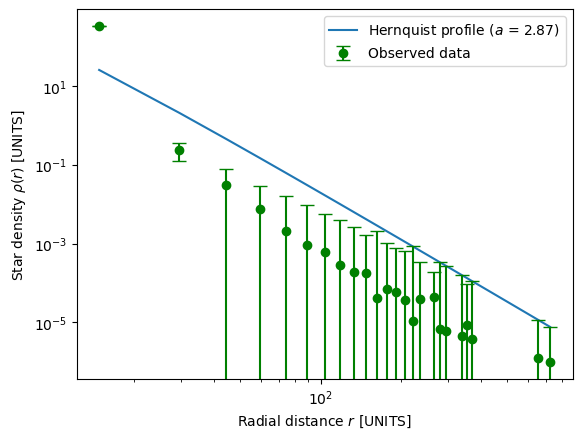

In [139]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Radial distance $r$ [UNITS]')
ax.set_ylabel(r'Star density $\rho(r)$ [UNITS]')

ax.plot(shell_outer_rad, rho_H, zorder=0, label=r'Hernquist profile ($a$ = {:.2f})'.format(a_data))
ax.errorbar(shell_outer_rad, rho_num, yerr=e_pos, zorder=1, fmt='o', capsize=5, color='green', label='Observed data')

ax.legend()

### 1.2 Step 2
- **Compute the direct N-Body forces between particles** (note that the array potential[i] is not needed for this purpose). Start by assuming a softening of the order of the mean interparticle separation in the system, then repeat the force calculation by experiment with different values of the softening and discuss your results.
- To check the direct force calculation result and its dependence on the softening choice, **compare it with the analytical force expected based on the application of Newton's second theorem for spherical potentials and plot the result** (use the book "Galactic Dynamics" by Binney and Tremaine as a main reference for the theoretical notions, in particular sec. 2.2 (most recent version of the book) or 2.1 (1987 version)).
- **Compute the relaxation timescale of the numerical model given the number of particles and the physical crossing timescale** (use the half-mass radius $R_{\text{hm}}$ and the circular velocity computed at the half-mass radius, $v_c = \sqrt{GM(R_{\text{hm}})/R_{\text{hm}}}$. Keeping in mind how the relaxation time formula is derived, **do you expect varying the value of the graviational softening to change the relaxation timescale?** In particular, do you expect it to increase or decrease if the softening is increased aobve the interparticle separation? Can you explain why?